In [1]:
from pycalphad import Database, Model, calculate, equilibrium, variables as v
from xarray import DataArray

In [2]:
class PrecipitateModel(Model):
    matrix_chempots = []
    @property
    def matrix_hyperplane(self):
        return sum(self.moles(self.nonvacant_elements[i])*self.matrix_chempots[i]
                   for i in range(len(self.nonvacant_elements)))
    @property
    def GM(self):
        return self.ast - self.matrix_hyperplane

In [21]:
import numpy as np

def parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    matrix_eq = equilibrium(dbf, comps, matrix_phase, conds)
    matrix_chempots = matrix_eq.MU.values.flatten()
    # This part will not work until mass balance constraint can be relaxed
    #precip = PrecipitateModel(dbf, comps, precipitate_phase)
    #precip.matrix_chempots = matrix_chempots
    #conds = {v.N: 1, v.P: 1e5, v.T: temp}
    #df_eq = equilibrium(dbf, comps, precipitate_phase, conds, model=precip)
    df_eq = calculate(dbf, comps, precipitate_phase, T=temp, N=1, P=1e5)
    df_eq['GM'] = df_eq.GM - df_eq.X.values[0,0,0].dot(matrix_chempots)
    selected_idx = df_eq.GM.argmax()
    return df_eq.isel(points=selected_idx)

def nucleation_barrier(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    "Spherical precipitate."
    # Numbers here are made up for demonstration purposes
    interfacial_energy = 250e-3 # J/m^2
    precipitate_volume = 7.3e-6 # m^3/mol

    precip_driving_force = parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    precip_driving_force = float(precip_driving_force.GM.values) # J/mol
    elastic_misfit_energy = 0 # J/mol
    barrier = 16./3 * interfacial_energy **3 / (precip_driving_force + elastic_misfit_energy) ** 2 # J/mol
    critical_radius = 2 * interfacial_energy / (precip_driving_force + elastic_misfit_energy) # m
    if critical_radius < 0:
        barrier = np.inf
    return barrier

def nucleation_rate(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp):
    g_star = nucleation_barrier(dbf, comps, matrix_phase, matrix_comp, precipitate_phase, temp)
    n_prefactor = 1e21
    zeldovich = 1e-3
    beta_attachment_rate = 1.0
    nucl_rate = n_prefactor * zeldovich * beta_attachment_rate * np.exp(-g_star/(8.3145*temp))
    return nucl_rate

dbf = Database('Al-Cu-Zr_Zhou.tdb')
comps = ['AL', 'CU', 'VA']

temps = np.linspace(300, 1000, 30)
results = []
for temp in temps:
    result = nucleation_rate(dbf, comps, 'BCC_A2', {v.X('CU'): 0.4}, 'AL2CU', temp)
    results.append(result)

[9.999999999922447e+17, 9.999999999937687e+17, 9.999999999949179e+17, 9.99999999995801e+17, 9.999999999964908e+17, 9.999999999970373e+17, 9.99999999997476e+17, 9.999999999978321e+17, 9.999999999981243e+17, 9.999999999983662e+17, 9.999999999985683e+17, 9.999999999987383e+17, 9.999999999988824e+17, 9.999999999990054e+17, 9.99999999999111e+17, 9.999999999992022e+17, 9.999999999992814e+17, 9.999999999993503e+17, 9.999999999994107e+17, 9.99999999999464e+17, 9.999999999995108e+17, 9.999999999995525e+17, 9.999999999995894e+17, 9.999999999996225e+17, 9.999999999996522e+17, 9.999999999996787e+17, 9.999999999997027e+17, 9.999999999997243e+17, 9.999999999997439e+17, 9.999999999997617e+17]


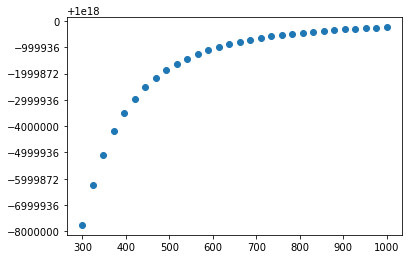

In [22]:
import matplotlib.pyplot as plt
print(results)
plt.scatter(temps, results)

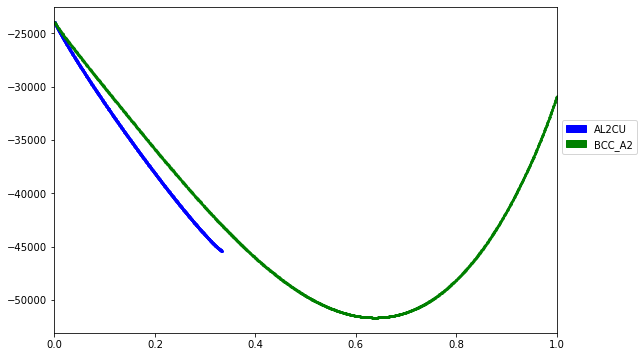

In [5]:
from pycalphad import calculate
import matplotlib.pyplot as plt
from pycalphad.plot.utils import phase_legend
import numpy as np

my_phases = ['AL2CU', 'BCC_A2']
legend_handles, colorlist = phase_legend(my_phases)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for name in my_phases:
    result = calculate(dbf, ['AL', 'CU', 'VA'], name, P=101325, T=800, output='GM')
    ax.scatter(result.X.sel(component='CU'), result.GM,
               marker='.', s=5, color=colorlist[name.upper()])
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()

In [6]:
dbf.phases

{'LIQUID': Phase({'name': 'LIQUID', 'constituents': (frozenset({Species('CU', 'CU1'), Species('ZR', 'ZR1'), Species('AL', 'AL1')}),), 'sublattices': (1.0,), 'model_hints': {'liquid': True}}),
 'AL2CU': Phase({'name': 'AL2CU', 'constituents': (frozenset({Species('AL', 'AL1')}), frozenset({Species('CU', 'CU1'), Species('AL', 'AL1')})), 'sublattices': (2.0, 1.0), 'model_hints': {}}),
 'AL2ZR': Phase({'name': 'AL2ZR', 'constituents': (frozenset({Species('CU', 'CU1'), Species('AL', 'AL1')}), frozenset({Species('ZR', 'ZR1')})), 'sublattices': (2.0, 1.0), 'model_hints': {}}),
 'AL2ZR3': Phase({'name': 'AL2ZR3', 'constituents': (frozenset({Species('CU', 'CU1'), Species('AL', 'AL1')}), frozenset({Species('ZR', 'ZR1')})), 'sublattices': (2.0, 3.0), 'model_hints': {}}),
 'AL3ZR2': Phase({'name': 'AL3ZR2', 'constituents': (frozenset({Species('CU', 'CU1'), Species('AL', 'AL1')}), frozenset({Species('ZR', 'ZR1')})), 'sublattices': (3.0, 2.0), 'model_hints': {}}),
 'AL3ZR4': Phase({'name': 'AL3ZR4', 